## Experimental Results 

F

In [1]:
import pickle

with open('train_generations-3.pkl', 'rb') as f:
    train_data = pickle.load(f)

In [3]:
with open('uncertainty_measures-2.pkl', 'rb') as f:
    uc_data = pickle.load(f)

In [4]:
with open('experiment_details-2.pkl', 'rb') as f:
    exp = pickle.load(f)

In [6]:
with open('validation_generations-2.pkl', 'rb') as f:
    val = pickle.load(f)

In [8]:
import numpy as np

In [11]:
def restore(filename):
    class Restored:
        name = f'{filename}'

    return Restored

result_dict_pickle = restore('uncertainty_measures-2.pkl')
with open(result_dict_pickle.name, "rb") as infile:
    result_dict = pickle.load(infile)

In [13]:
with open('uncertainty_measures_se_calc-2.pkl', 'rb') as f:
    uc_data_more = pickle.load(f)

In [15]:
uc_data_more.keys()

dict_keys(['uncertainty_measures', 'semantic_ids', 'validation_is_false', 'validation_unanswerable', 'alt_validation_accuracies_mean', 'alt_validation_is_false'])

## Eval Utils

In [22]:
"""Functions for performance evaluation, mainly used in analyze_results.py."""
import numpy as np
import scipy
from sklearn import metrics


# pylint: disable=missing-function-docstring


def bootstrap(function, rng, n_resamples=1000):
    def inner(data):
        bs = scipy.stats.bootstrap(
            (data, ), function, n_resamples=n_resamples, confidence_level=0.9,
            random_state=rng)
        return {
            'std_err': bs.standard_error,
            'low': bs.confidence_interval.low,
            'high': bs.confidence_interval.high
        }
    return inner


def auroc(y_true, y_score):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    del thresholds
    return metrics.auc(fpr, tpr)


def accuracy_at_quantile(accuracies, uncertainties, quantile):
    cutoff = np.quantile(uncertainties, quantile)
    select = uncertainties <= cutoff
    return np.mean(accuracies[select])


def area_under_thresholded_accuracy(accuracies, uncertainties):
    quantiles = np.linspace(0.1, 1, 20)
    select_accuracies = np.array([accuracy_at_quantile(accuracies, uncertainties, q) for q in quantiles])
    dx = quantiles[1] - quantiles[0]
    area = (select_accuracies * dx).sum()
    return area


# Need wrappers because scipy expects 1D data.
def compatible_bootstrap(func, rng):
    def helper(y_true_y_score):
        # this function is called in the bootstrap
        y_true = np.array([i['y_true'] for i in y_true_y_score])
        y_score = np.array([i['y_score'] for i in y_true_y_score])
        out = func(y_true, y_score)
        return out

    def wrap_inputs(y_true, y_score):
        return [{'y_true': i, 'y_score': j} for i, j in zip(y_true, y_score)]

    def converted_func(y_true, y_score):
        y_true_y_score = wrap_inputs(y_true, y_score)
        return bootstrap(helper, rng=rng)(y_true_y_score)
    return converted_func

## Analyze Run

In [23]:
import warnings
warnings.filterwarnings("ignore")

"""Analyze uncertainty predictions."""
import argparse
import functools
import logging
import os
import pickle

import numpy as np

#from uncertainty.utils import utils
#from uncertainty.utils.eval_utils import (
#    bootstrap, compatible_bootstrap, auroc, accuracy_at_quantile,
#    area_under_thresholded_accuracy)


#utils.setup_logger()

result_dict = {}

UNC_MEAS = 'uncertainty_measures_se_calc_1.pkl'


def analyze_run(answer_fractions_mode='default',
        experiment_lot=None, entity=None):

    '''Analyze the uncertainty measures for a given wandb run id.'''
    #logging.info('Analyzing wandb_runid `%s`.', wandb_runid)

    # Set up evaluation metrics.
    if answer_fractions_mode == 'default':
        answer_fractions = [0.8, 0.9, 0.95, 1.0]
    elif answer_fractions_mode == 'finegrained':
        answer_fractions = [round(i, 3) for i in np.linspace(0, 1, 20+1)]
    else:
        raise ValueError

    rng = np.random.default_rng(41)
    eval_metrics = dict(zip(
        ['AUROC', 'area_under_thresholded_accuracy', 'mean_uncertainty'],
        list(zip(
            [auroc, area_under_thresholded_accuracy, np.mean],
            [compatible_bootstrap, compatible_bootstrap, bootstrap]
        )),
    ))
    for answer_fraction in answer_fractions:
        key = f'accuracy_at_{answer_fraction}_answer_fraction'
        eval_metrics[key] = [
            functools.partial(accuracy_at_quantile, quantile=answer_fraction),
            compatible_bootstrap]

    #if wandb.run is None:
    #    init_wandb(
    #        wandb_runid, assign_new_wandb_id=assign_new_wandb_id,
    #        experiment_lot=experiment_lot, entity=entity)

    #elif wandb.run.id != wandb_runid:
    #    raise

    # Load the results dictionary from a pickle file.
    with open(f'{UNC_MEAS}', 'rb') as file:
        results_old = pickle.load(file)

    result_dict = {'performance': {}, 'uncertainty': {}}

    # First: Compute Simple Accuracy metrics of the model predictions.
    all_accuracies = dict()
    if 'alt_validation_is_false' in results_old:
        all_accuracies.update({name: 1 - np.array(data) for name, data in results_old['alt_validation_is_false'].items()})
    all_accuracies['accuracy'] = 1 - np.array(results_old['validation_is_false'])

    for name, target in all_accuracies.items():
        result_dict['performance'][name] = {}
        result_dict['performance'][name]['mean'] = np.mean(target)
        result_dict['performance'][name]['bootstrap'] = bootstrap(np.mean, rng)(target)

    rum = results_old['uncertainty_measures']
    if 'p_false' in rum and 'p_false_fixed' not in rum:
        # Restore log probs true: y = 1 - x --> x = 1 - y.
        # Convert to probs --> np.exp(1 - y).
        # Convert to p_false --> 1 - np.exp(1 - y).
        rum['p_false_fixed'] = [1 - np.exp(1 - x) for x in rum['p_false']]

    # Next: Uncertainty Measures.
    # Iterate through the dictionary and compute additional metrics for each measure.
    for measure_name, measure_values in rum.items():
        print(f'Computing for uncertainty measure `{measure_name}`.')

        # Validation accuracy.
        validation_is_falses = [
            results_old['validation_is_false'],
            results_old['validation_unanswerable']
        ]

        logging_names = ['', '_UNANSWERABLE']

        # Check if we have additional predictions for this measure.
        if 'alt_validation_is_false' in results_old:
            if measure_name in (u_m := results_old['alt_validation_is_false']):
                validation_is_falses.append(u_m[measure_name])
                logging_names.append(f'_max_from_{measure_name}')

        # Iterate over predictions of 'falseness' or 'answerability'.
        for validation_is_false, logging_name in zip(validation_is_falses, logging_names):
            name = measure_name + logging_name
            result_dict['uncertainty'][name] = {}

            validation_is_false = np.array(validation_is_false)
            validation_accuracy = 1 - validation_is_false
            if len(measure_values) > len(validation_is_false):
                # This can happen, but only for p_false.
                if 'p_false' not in measure_name:
                    raise ValueError
                print(f'More measure values for {measure_name} than in validation_is_false. Len(measure values): {len(measure_values)}, Len(validation_is_false): {len(validation_is_false)}')
                
                measure_values = measure_values[:len(validation_is_false)]

            fargs = {
                'AUROC': [validation_is_false, measure_values],
                'area_under_thresholded_accuracy': [validation_accuracy, measure_values],
                'mean_uncertainty': [measure_values]}

            for answer_fraction in answer_fractions:
                fargs[f'accuracy_at_{answer_fraction}_answer_fraction'] = [validation_accuracy, measure_values]

            for fname, (function, bs_function) in eval_metrics.items():
                metric_i = function(*fargs[fname])
                result_dict['uncertainty'][name][fname] = {}
                result_dict['uncertainty'][name][fname]['mean'] = metric_i
                print(f"{fname} for measure name `{name}`: {metric_i}")
                result_dict['uncertainty'][name][fname]['bootstrap'] = bs_function(
                    function, rng)(*fargs[fname])

In [24]:
analyze_run('default', 'GSM8k Mistral Experiment')

Computing for uncertainty measure `p_false`.
AUROC for measure name `p_false`: 0.6398809523809523
area_under_thresholded_accuracy for measure name `p_false`: 0.20405585112704
mean_uncertainty for measure name `p_false`: 3.469341747760773
accuracy_at_0.8_answer_fraction for measure name `p_false`: 0.175
accuracy_at_0.9_answer_fraction for measure name `p_false`: 0.17777777777777778
accuracy_at_0.95_answer_fraction for measure name `p_false`: 0.1702127659574468
accuracy_at_1.0_answer_fraction for measure name `p_false`: 0.16
AUROC for measure name `p_false_UNANSWERABLE`: nan
area_under_thresholded_accuracy for measure name `p_false_UNANSWERABLE`: 0.9473684210526319
mean_uncertainty for measure name `p_false_UNANSWERABLE`: 3.469341747760773
accuracy_at_0.8_answer_fraction for measure name `p_false_UNANSWERABLE`: 1.0
accuracy_at_0.9_answer_fraction for measure name `p_false_UNANSWERABLE`: 1.0
accuracy_at_0.95_answer_fraction for measure name `p_false_UNANSWERABLE`: 1.0
accuracy_at_1.0_answ

area_under_thresholded_accuracy for measure name `semantic_entropy_sum-normalized_max_from_semantic_entropy_sum-normalized`: 0.20269357236195892
mean_uncertainty for measure name `semantic_entropy_sum-normalized_max_from_semantic_entropy_sum-normalized`: 1.325678788737749
accuracy_at_0.8_answer_fraction for measure name `semantic_entropy_sum-normalized_max_from_semantic_entropy_sum-normalized`: 0.225
accuracy_at_0.9_answer_fraction for measure name `semantic_entropy_sum-normalized_max_from_semantic_entropy_sum-normalized`: 0.2
accuracy_at_0.95_answer_fraction for measure name `semantic_entropy_sum-normalized_max_from_semantic_entropy_sum-normalized`: 0.19148936170212766
accuracy_at_1.0_answer_fraction for measure name `semantic_entropy_sum-normalized_max_from_semantic_entropy_sum-normalized`: 0.18
Computing for uncertainty measure `semantic_entropy_sum-normalized-rao`.
AUROC for measure name `semantic_entropy_sum-normalized-rao`: 0.3913690476190476
area_under_thresholded_accuracy for m

area_under_thresholded_accuracy for measure name `semantic_entropy_sum_sum-normalized`: 0.13865190183875853
mean_uncertainty for measure name `semantic_entropy_sum_sum-normalized`: 2.1070027873138306
accuracy_at_0.8_answer_fraction for measure name `semantic_entropy_sum_sum-normalized`: 0.2
accuracy_at_0.9_answer_fraction for measure name `semantic_entropy_sum_sum-normalized`: 0.17777777777777778
accuracy_at_0.95_answer_fraction for measure name `semantic_entropy_sum_sum-normalized`: 0.1702127659574468
accuracy_at_1.0_answer_fraction for measure name `semantic_entropy_sum_sum-normalized`: 0.16
AUROC for measure name `semantic_entropy_sum_sum-normalized_UNANSWERABLE`: nan
area_under_thresholded_accuracy for measure name `semantic_entropy_sum_sum-normalized_UNANSWERABLE`: 0.9473684210526319
mean_uncertainty for measure name `semantic_entropy_sum_sum-normalized_UNANSWERABLE`: 2.1070027873138306
accuracy_at_0.8_answer_fraction for measure name `semantic_entropy_sum_sum-normalized_UNANSWERA

## Data Check

In [26]:
from datasets import Dataset

train_dt_out = Dataset.from_dict(train_data)

In [28]:
train_data['286771034780795713094628084141832338314']

{'question': 'John writes 20 pages a day.  How long will it take him to write 3 books that are 400 pages each?',
 'context': None,
 'most_likely_answer': {'response': '10',
  'token_log_likelihoods': [0.0,
   -0.01978309080004692,
   -0.08339661359786987,
   -0.0040115611627697945,
   0.0],
  'embedding': tensor([[ 5.3697,  1.7037,  4.1474,  ...,  1.3120,  1.0131, -2.1139]]),
  'accuracy': 0.0,
  'emb_last_tok_before_gen': tensor([[[-1.8005e-03,  3.0518e-04,  6.9046e-04,  ...,  1.9379e-03,
             1.1597e-03, -3.4904e-04]],
  
          [[ 1.5838e-03, -1.0471e-03, -9.7129e-04,  ...,  2.6795e-03,
             4.6503e-03, -2.3382e-04]],
  
          [[ 2.9105e-04,  2.4750e-03, -2.8649e-03,  ..., -1.1999e-04,
             2.2987e-03,  9.1348e-04]],
  
          ...,
  
          [[-3.1760e-01, -2.7634e-01, -1.8132e-01,  ..., -2.4232e-01,
            -1.7523e-01,  1.2092e-01]],
  
          [[-2.3982e-01, -2.2477e-01, -3.3317e-01,  ..., -1.7346e-01,
            -1.8603e-02, -1.1220e-0

In [29]:
train_data['294725624892679347685282356874501274037']

{'question': 'In a 90-minute soccer game, Mark played 20 minutes, then rested after. He then played for another 35 minutes. How long was he on the sideline?',
 'context': None,
 'most_likely_answer': {'response': '35',
  'token_log_likelihoods': [0.0, 0.0, 0.0, 0.0, 0.0],
  'embedding': tensor([[ 5.2160,  3.4133,  3.1108,  ...,  1.6301,  2.8515, -3.8744]]),
  'accuracy': 1.0,
  'emb_last_tok_before_gen': tensor([[[-3.0518e-03,  2.8610e-04,  2.4567e-03,  ...,  1.3733e-03,
             6.5231e-04,  2.1973e-03]],
  
          [[-1.8565e-03,  3.1062e-03,  4.3039e-03,  ...,  5.1326e-04,
             1.3745e-03, -3.1761e-04]],
  
          [[-2.1601e-03,  2.1028e-03,  5.8040e-03,  ..., -2.7997e-03,
             3.5391e-03, -2.1383e-03]],
  
          ...,
  
          [[-5.1356e-01,  3.6528e-01, -1.6977e-01,  ..., -6.6863e-02,
            -1.1865e-01, -2.8903e-02]],
  
          [[-4.8294e-01,  4.4002e-01, -1.8879e-01,  ..., -7.2970e-02,
            -1.3478e-01, -2.6002e-01]],
  
          [

In [30]:
train_data['294725624892679347685282356874501274037']['most_likely_answer']['emb_last_tok_before_gen'][0][0]

tensor([-0.0031,  0.0003,  0.0025,  ...,  0.0014,  0.0007,  0.0022])

In [31]:
import pandas as pd

train_df = pd.DataFrame(train_data)

In [32]:
train_consolidated_df = pd.DataFrame()
temp_lt = []
for td in train_data.keys():

    temp_dict = dict()
    temp_dict['id'] = td
    
    for key in ['question', 'context', 'reference', 'responses']:
        temp_dict[key] = train_data[td][key]
        
    temp_dict['accuracy'] = train_data[td]['most_likely_answer']['accuracy']
    temp_dict['token_log_likehoods'] = train_data[td]['most_likely_answer']['token_log_likelihoods']
    temp_dict['predicated_response'] = train_data[td]['most_likely_answer']['response']
    temp_dict['correct_response'] = train_data[td]['reference']['answers']['text'][0]
    
    temp_lt.append(temp_dict)
    #temp_df = pd.DataFrame(temp_dict)
    
train_consolidated_df = pd.DataFrame(temp_lt)

In [33]:
train_consolidated_df

,id,question,context,reference,responses,accuracy,token_log_likehoods,predicated_response,correct_response
0,286771034780795713094628084141832338314,John writes 20 pages a day. How long will it ...,None,"{'answers': {'answer_start': [104], 'text': ['...",[],0.0,"[0.0, -0.01978309080004692, -0.083396613597869...",10,60
1,271111457272920910577561505594900175215,"In 2021, Wayne is 37 years old. His brother P...",None,"{'answers': {'answer_start': [265], 'text': ['...",[],0.0,"[0.0, 0.0, 0.0, -0.004086359404027462, -0.0304...",1982,1979
2,20588521139017150728967757871183520630,Angeli had 90 assorted candies. One-third of t...,None,"{'answers': {'answer_start': [284], 'text': ['...",[],0.0,"[0.0, -0.0003586364327929914, -0.0124224489554...",12,40
3,194990638893934777306164875901002672337,John decides to get gym memberships so he can ...,None,"{'answers': {'answer_start': [431], 'text': ['...",[],0.0,"[-9.536738616588991e-07, -0.008252923376858234...",120,650
4,51318408806733847611913707244720185222,Emilia needs 42 cartons of berries to make a b...,None,"{'answers': {'answer_start': [158], 'text': ['...",[],1.0,"[0.0, 0.0, 0.0, 0.0, 0.0]",33,33
...,...,...,...,...,...,...,...,...,...
95,277555267621434397316369870784990477427,An 18-month magazine subscription is normally ...,None,"{'answers': {'answer_start': [191], 'text': ['...",[],0.0,"[-3.480850500636734e-05, -0.003220968181267380...",10,9
96,115676958056129697007444330802795134306,If 24 out of every 60 individuals like footbal...,None,"{'answers': {'answer_start': [387], 'text': ['...",[],0.0,"[0.0, -0.0006643710657954216, -0.0043313740752...",100,50
97,237853966997633280789990788704541519286,Jon buys 2 coffees a day from his favorite cof...,None,"{'answers': {'answer_start': [94], 'text': ['1...",[],0.0,"[-4.887569048150908e-06, -0.02452009916305542,...",60,120
98,166639430387465363641716336001283074725,Alani earned $45 for 3 hours of baby-sitting. ...,None,"{'answers': {'answer_start': [101], 'text': ['...",[],0.0,"[0.0, -0.4604203701019287, -2.3841574147809297...",2,5


In [34]:
train_consolidated_df[train_consolidated_df.accuracy==1.0].shape

(6, 9)

In [35]:
train_consolidated_df.shape

(100, 9)

In [39]:
val

{'224521086803038795755248928444387788487': {'question': 'While walking down the street with his 3 younger siblings, Greg found $20. To be fair to his siblings, he decided to split the money equally. How much money did each of them get?',
  'context': None,
  'most_likely_answer': {'response': '5',
   'token_log_likelihoods': [-2.1815061700181104e-05, 0.0, 0.0, 0.0],
   'embedding': tensor([[ 5.3022,  1.6424,  5.8250,  ...,  3.1790,  1.8724, -3.6925]]),
   'accuracy': 1.0,
   'emb_last_tok_before_gen': tensor([[[-3.0518e-03,  2.8610e-04,  2.4567e-03,  ...,  1.3733e-03,
              6.5231e-04,  2.1973e-03]],
   
           [[ 7.2136e-04, -4.5142e-04,  2.4299e-03,  ...,  2.1630e-04,
              5.0330e-03,  2.7441e-03]],
   
           [[-7.1036e-04,  3.0522e-03,  3.1575e-03,  ..., -2.5002e-03,
              2.8901e-03,  3.7419e-03]],
   
           ...,
   
           [[-4.7757e-01,  1.3767e-01,  3.1873e-01,  ..., -1.7750e-01,
              8.3024e-02, -1.1773e-01]],
   
           

In [40]:
val_consolidated_df = pd.DataFrame()
temp_lt = []
for td in val.keys():

    temp_dict = dict()
    temp_dict['id'] = td
    
    for key in ['question', 'context', 'reference', 'responses']:
        temp_dict[key] = val[td][key]
        
    temp_dict['accuracy'] = val[td]['most_likely_answer']['accuracy']
    temp_dict['token_log_likehoods'] = val[td]['most_likely_answer']['token_log_likelihoods']
    temp_dict['predicated_response'] = val[td]['most_likely_answer']['response']
    temp_dict['correct_response'] = val[td]['reference']['answers']['text'][0]
    
    temp_lt.append(temp_dict)
    #temp_df = pd.DataFrame(temp_dict)
    
val_consolidated_df = pd.DataFrame(temp_lt)

In [41]:
val_consolidated_df

,id,question,context,reference,responses,accuracy,token_log_likehoods,predicated_response,correct_response
0,224521086803038795755248928444387788487,While walking down the street with his 3 young...,None,"{'answers': {'answer_start': [182], 'text': ['...","[(5, [-2.1815061700181104e-05, 0.0, 0.0, 0.0],...",1.0,"[-2.1815061700181104e-05, 0.0, 0.0, 0.0]",5,5
1,238709339889571599525018800822417269214,Twenty kids went out on a school trip. In one ...,None,"{'answers': {'answer_start': [416], 'text': ['...","[(64, [0.0, -0.03841890022158623, 0.0, 0.0, 0....",0.0,"[0.0, -0.03841890022158623, 0.0, 0.0, 0.0]",64,300
2,15046788331425664074948480042056147642,Tim gets a promotion that offers him a 5% rais...,None,"{'answers': {'answer_start': [334], 'text': ['...","[(260000, [-2.3841855067985307e-07, -4.2915253...",0.0,"[-2.3841855067985307e-07, -4.291525328881107e-...",260000,262500
3,283432900406973735678893692133295193033,Carlos is planting a lemon tree. The tree will...,None,"{'answers': {'answer_start': [316], 'text': ['...","[(10, [0.0, -0.0022436226718127728, -0.0011948...",0.0,"[0.0, -0.0022436226718127728, -0.0011948358733...",10,13
4,155418538417837272732789092517325541548,Jana has 27 puppies. Two thirds of Jana's pupp...,None,"{'answers': {'answer_start': [94], 'text': ['6...","[(9, [0.0, -0.4122057259082794, 0.0, 0.0], [te...",0.0,"[0.0, -0.4122057259082794, 0.0, 0.0]",9,6
...,...,...,...,...,...,...,...,...,...
95,114812945027821223102608461783223212797,"Bill bakes 300 rolls, 120 chocolate croissants...",None,"{'answers': {'answer_start': [697], 'text': ['...","[(10, [0.0, -0.00989649910479784, -2.159328222...",0.0,"[0.0, -0.00989649910479784, -0.125652119517326...",120,280
96,82749223310230061645707481895327228252,How much does it cost you for lunch today at S...,None,"{'answers': {'answer_start': [171], 'text': ['...","[(120, [-0.00047958316281437874, -0.0429005585...",0.0,"[-0.00047958316281437874, -0.04290055856108665...",120,160
97,147555836109925024886760921467143500799,Maria was charging her power bank before going...,None,"{'answers': {'answer_start': [237], 'text': ['...","[(70, [0.0, -0.034171588718891144, -9.50052926...",0.0,"[0.0, -0.034171588718891144, -9.50052926782518...",70,94
98,61627343206363414324746598290020341705,Oscar has 24 lollipops and eats 2 on his way t...,None,"{'answers': {'answer_start': [383], 'text': ['...","[(24, [0.0, -0.0003477922291494906, 0.0, 0.0, ...",0.0,"[0.0, -0.0003477922291494906, 0.0, 0.0, 0.0]",24,31


In [46]:
val_consolidated_entropies_df = pd.DataFrame()
temp_lt = []

for i, id in enumerate(val):

    temp_dict = dict()
    temp_dict['id'] = id
    
    for key in ['question', 'context', 'reference', 'responses']:
        temp_dict[key] = val[id][key]
        
    temp_dict['accuracy'] = val[id]['most_likely_answer']['accuracy']
    temp_dict['token_log_likehoods'] = val[id]['most_likely_answer']['token_log_likelihoods']
    temp_dict['predicated_response'] = val[id]['most_likely_answer']['response']
    temp_dict['correct_response'] = val[id]['reference']['answers']['text'][0]
    
    temp_dict['semantic_entropy'] = uc_data_more['uncertainty_measures']['semantic_entropy'][i]
    temp_dict['p_false'] = uc_data_more['uncertainty_measures']['p_false'][i]
    temp_dict['p_false_fixed'] = uc_data_more['uncertainty_measures']['p_false_fixed'][i]
    temp_dict['cluster_assignment_entropy'] = uc_data_more['uncertainty_measures']['cluster_assignment_entropy'][i]
    temp_dict['regular_entropy'] = uc_data_more['uncertainty_measures']['semantic_entropy'][i]
    temp_dict['semantic_entropy_sum-normalized'] = uc_data_more['uncertainty_measures']['semantic_entropy_sum-normalized'][i]
    temp_dict['semantic_entropy_sum-normalized-rao'] = uc_data_more['uncertainty_measures']['semantic_entropy_sum-normalized-rao'][i]
    temp_dict['semantic_entropy_cmean'] = uc_data_more['uncertainty_measures']['semantic_entropy_cmean'][i]
    temp_dict['regular_entropy_sum'] = uc_data_more['uncertainty_measures']['regular_entropy_sum'][i]
    temp_dict['semantic_entropy_sum'] = uc_data_more['uncertainty_measures']['semantic_entropy_sum'][i]
    temp_dict['semantic_entropy_sum_sum-normalized'] = uc_data_more['uncertainty_measures']['semantic_entropy_sum_sum-normalized'][i]
    temp_dict['semantic_entropy_sum_sum-normalized-rao'] = uc_data_more['uncertainty_measures']['semantic_entropy_sum_sum-normalized-rao'][i]
    temp_dict['semantic_entropy_sum_cmean'] = uc_data_more['uncertainty_measures']['semantic_entropy_sum_cmean'][i]
    temp_dict['p_ik'] = uc_data_more['uncertainty_measures']['p_ik'][i]
    temp_dict['semantic_entropy_sum'] = uc_data_more['uncertainty_measures']['semantic_entropy_sum'][i]

    
    temp_lt.append(temp_dict)
    #temp_df = pd.DataFrame(temp_dict)
    
val_consolidated_entropies_df = pd.DataFrame(temp_lt)

In [47]:
val_consolidated_entropies_df

,id,question,context,reference,responses,accuracy,token_log_likehoods,predicated_response,correct_response,semantic_entropy,...,regular_entropy,semantic_entropy_sum-normalized,semantic_entropy_sum-normalized-rao,semantic_entropy_cmean,regular_entropy_sum,semantic_entropy_sum,semantic_entropy_sum_sum-normalized,semantic_entropy_sum_sum-normalized-rao,semantic_entropy_sum_cmean,p_ik
0,224521086803038795755248928444387788487,While walking down the street with his 3 young...,None,"{'answers': {'answer_start': [182], 'text': ['...","[(5, [-2.1815061700181104e-05, 0.0, 0.0, 0.0],...",1.0,"[-2.1815061700181104e-05, 0.0, 0.0, 0.0]",5,5,5.000005,...,5.000005,-0.000000e+00,-0.000000e+00,0.000005,0.000022,5.000022,1.110223e-16,1.110223e-16,0.000022,0.993812
1,238709339889571599525018800822417269214,Twenty kids went out on a school trip. In one ...,None,"{'answers': {'answer_start': [416], 'text': ['...","[(64, [0.0, -0.03841890022158623, 0.0, 0.0, 0....",0.0,"[0.0, -0.03841890022158623, 0.0, 0.0, 0.0]",64,300,4.314537,...,4.314537,-0.000000e+00,-0.000000e+00,0.007684,0.038419,4.345272,-0.000000e+00,-0.000000e+00,0.038419,0.987858
2,15046788331425664074948480042056147642,Tim gets a promotion that offers him a 5% rais...,None,"{'answers': {'answer_start': [334], 'text': ['...","[(260000, [-2.3841855067985307e-07, -4.2915253...",0.0,"[-2.3841855067985307e-07, -4.291525328881107e-...",260000,262500,3.915589,...,3.915589,-0.000000e+00,-0.000000e+00,0.014202,0.127815,4.029202,-0.000000e+00,-0.000000e+00,0.127815,0.999866
3,283432900406973735678893692133295193033,Carlos is planting a lemon tree. The tree will...,None,"{'answers': {'answer_start': [316], 'text': ['...","[(10, [0.0, -0.0022436226718127728, -0.0011948...",0.0,"[0.0, -0.0022436226718127728, -0.0011948358733...",10,13,3.614393,...,3.614393,-0.000000e+00,-0.000000e+00,0.000688,0.003438,3.617144,-0.000000e+00,-0.000000e+00,0.003438,0.999988
4,155418538417837272732789092517325541548,Jana has 27 puppies. Two thirds of Jana's pupp...,None,"{'answers': {'answer_start': [94], 'text': ['6...","[(9, [0.0, -0.4122057259082794, 0.0, 0.0], [te...",0.0,"[0.0, -0.4122057259082794, 0.0, 0.0]",9,6,3.493614,...,3.493614,1.110223e-16,1.110223e-16,0.103051,0.412206,3.802768,-0.000000e+00,-0.000000e+00,0.412206,0.998963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,114812945027821223102608461783223212797,"Bill bakes 300 rolls, 120 chocolate croissants...",None,"{'answers': {'answer_start': [697], 'text': ['...","[(10, [0.0, -0.00989649910479784, -2.159328222...",0.0,"[0.0, -0.00989649910479784, -0.125652119517326...",120,280,2.482160,...,2.482160,1.840380e+00,1.002587e+00,0.360291,1.181804,4.072726,2.779479e+00,5.377357e-01,1.950858,0.996689
96,82749223310230061645707481895327228252,How much does it cost you for lunch today at S...,None,"{'answers': {'answer_start': [171], 'text': ['...","[(120, [-0.00047958316281437874, -0.0429005585...",0.0,"[-0.00047958316281437874, -0.04290055856108665...",120,160,2.261825,...,2.261825,1.804615e+00,1.271809e-01,0.327438,0.208129,3.575198,3.055759e+00,1.579525e-02,1.640811,0.999993
97,147555836109925024886760921467143500799,Maria was charging her power bank before going...,None,"{'answers': {'answer_start': [237], 'text': ['...","[(70, [0.0, -0.034171588718891144, -9.50052926...",0.0,"[0.0, -0.034171588718891144, -9.50052926782518...",70,94,3.626769,...,3.626769,3.131193e+00,3.387521e-01,0.603865,0.531902,6.152065,5.491979e+00,5.248652e-02,3.129161,0.998186
98,61627343206363414324746598290020341705,Oscar has 24 lollipops and eats 2 on his way t...,None,"{'answers': {'answer_start': [383], 'text': ['...","[(24, [0.0, -0.0003477922291494906, 0.0, 0.0, ...",0.0,"[0.0, -0.0003477922291494906, 0.0, 0.0, 0.0]",24,31,0.404950,...,0.404950,2.220446e-16,2.220446e-16,0.000070,0.000348,0.405228,2.220446e-16,2.220446e-16,0.000348,0.999825


In [48]:
val_consolidated_entropies_df[val_consolidated_entropies_df.accuracy==1.0]

,id,question,context,reference,responses,accuracy,token_log_likehoods,predicated_response,correct_response,semantic_entropy,...,regular_entropy,semantic_entropy_sum-normalized,semantic_entropy_sum-normalized-rao,semantic_entropy_cmean,regular_entropy_sum,semantic_entropy_sum,semantic_entropy_sum_sum-normalized,semantic_entropy_sum_sum-normalized-rao,semantic_entropy_sum_cmean,p_ik
0,224521086803038795755248928444387788487,While walking down the street with his 3 young...,None,"{'answers': {'answer_start': [182], 'text': ['...","[(5, [-2.1815061700181104e-05, 0.0, 0.0, 0.0],...",1.0,"[-2.1815061700181104e-05, 0.0, 0.0, 0.0]",5,5,5.000005,...,5.000005,-0.000000e+00,-0.000000e+00,5.453765e-06,0.000022,5.000022,1.110223e-16,1.110223e-16,0.000022,0.993812
14,25942288222300606812428636976736828495,Sally has realized she did not receive a full ...,None,"{'answers': {'answer_start': [127], 'text': ['...","[(80, [0.0, -1.0490362910786644e-05, 0.0, 0.0,...",1.0,"[0.0, -1.0490362910786644e-05, 0.0, 0.0, 0.0]",80,80,2.291952,...,2.291952,3.330669e-16,3.330669e-16,2.098073e-06,0.000010,2.291960,3.330669e-16,3.330669e-16,0.000010,0.999925
30,187322730759507603275054011727533089615,"At a certain grade level, three-fourths of stu...",None,"{'answers': {'answer_start': [146], 'text': ['...","[(80, [0.0, -0.031383439898490906, 0.0, 0.0, 0...",1.0,"[0.0, -0.031383439898490906, 0.0, 0.0, 0.0]",80,80,3.421925,...,3.421925,1.810823e+00,1.259221e-01,4.521461e-01,0.319041,5.230509,3.567220e+00,6.488774e-03,2.260731,0.999998
35,311663727266000255973462621819517730887,Adam wants to eat some sliced apples. A large ...,None,"{'answers': {'answer_start': [236], 'text': ['...","[(15, [0.0, -0.0013266343157738447, -0.0345873...",1.0,"[0.0, -0.0013266343157738447, -0.0345873907208...",15,15,1.423664,...,1.423664,2.220446e-16,2.220446e-16,7.182805e-03,0.035914,1.452395,-0.000000e+00,-0.000000e+00,0.035914,0.999156
36,246475026734455094593111047570353511274,"While on vacation in Bali, Thea bought a hat f...",None,"{'answers': {'answer_start': [206], 'text': ['...","[(10, [-0.012828091159462929, -2.8610188564925...",1.0,"[-0.012828091159462929, -2.861018856492592e-06...",10,10,1.391648,...,1.391648,2.220446e-16,2.220446e-16,2.566190e-03,0.012831,1.401913,2.220446e-16,2.220446e-16,0.012831,0.999720
49,300963719180455095843826986552410556662,A class of 200 students is split into 3 groups...,None,"{'answers': {'answer_start': [285], 'text': ['...","[(60, [0.0, -2.0265558760002023e-06, 0.0, 0.0,...",1.0,"[0.0, -2.0265558760002023e-06, 0.0, 0.0, 0.0]",60,60,1.087977,...,1.087977,-0.000000e+00,-0.000000e+00,4.053112e-07,0.000002,1.087979,-0.000000e+00,-0.000000e+00,0.000002,0.999290
55,196408460853079823783064810452962223720,Colby loves going to the movies and every mont...,None,"{'answers': {'answer_start': [520], 'text': ['...","[(1, [0.0, -0.07533630728721619, 0.0, 0.0], [t...",1.0,"[0.0, -0.07533630728721619, 0.0, 0.0]",1,1,2.673158,...,2.673158,1.645088e+00,1.639472e-01,3.419275e-01,0.259961,3.698941,2.580633e+00,3.548633e-02,1.367710,0.971868
68,191265340272242845078791895670069317511,The three angles in a triangle add up to 180 d...,None,"{'answers': {'answer_start': [135], 'text': ['...","[(90, [0.0, -0.7627560496330261, 0.0, 0.0, 0.0...",1.0,"[0.0, -0.7627560496330261, 0.0, 0.0, 0.0]",90,90,1.592832,...,1.592832,7.010307e-01,6.853050e-01,1.286188e-01,0.688608,2.159650,7.073800e-01,6.790486e-01,0.695437,0.996675
71,327032920885905251740886932846893349646,"There are 26 countries in South America and, i...",None,"{'answers': {'answer_start': [182], 'text': ['...","[(130000, [0.0, -2.90866428258596e-05, 0.0, 0....",1.0,"[0.0, -2.90866428258596e-05, 0.0, 0.0, -2.0146...",130000,130000,0.723342,...,0.723342,7.771561e-16,7.771561e-16,7.629304e-06,0.000069,0.723403,-2.220446e-16,-2.220446e-16,0.000069,0.999987
80,100975898993494087254468753746645127431,"A stickler for health, Octavia drinks half the...",None,"{'answers': {'answer_start': [371], 'text': ['...","[(10,

In [49]:
val_consolidated_entropies_df[val_consolidated_entropies_df.accuracy==0.0]

,id,question,context,reference,responses,accuracy,token_log_likehoods,predicated_response,correct_response,semantic_entropy,...,regular_entropy,semantic_entropy_sum-normalized,semantic_entropy_sum-normalized-rao,semantic_entropy_cmean,regular_entropy_sum,semantic_entropy_sum,semantic_entropy_sum_sum-normalized,semantic_entropy_sum_sum-normalized-rao,semantic_entropy_sum_cmean,p_ik
1,238709339889571599525018800822417269214,Twenty kids went out on a school trip. In one ...,None,"{'answers': {'answer_start': [416], 'text': ['...","[(64, [0.0, -0.03841890022158623, 0.0, 0.0, 0....",0.0,"[0.0, -0.03841890022158623, 0.0, 0.0, 0.0]",64,300,4.314537,...,4.314537,-0.000000e+00,-0.000000e+00,0.007684,0.038419,4.345272,-0.000000e+00,-0.000000e+00,0.038419,0.987858
2,15046788331425664074948480042056147642,Tim gets a promotion that offers him a 5% rais...,None,"{'answers': {'answer_start': [334], 'text': ['...","[(260000, [-2.3841855067985307e-07, -4.2915253...",0.0,"[-2.3841855067985307e-07, -4.291525328881107e-...",260000,262500,3.915589,...,3.915589,-0.000000e+00,-0.000000e+00,0.014202,0.127815,4.029202,-0.000000e+00,-0.000000e+00,0.127815,0.999866
3,283432900406973735678893692133295193033,Carlos is planting a lemon tree. The tree will...,None,"{'answers': {'answer_start': [316], 'text': ['...","[(10, [0.0, -0.0022436226718127728, -0.0011948...",0.0,"[0.0, -0.0022436226718127728, -0.0011948358733...",10,13,3.614393,...,3.614393,-0.000000e+00,-0.000000e+00,0.000688,0.003438,3.617144,-0.000000e+00,-0.000000e+00,0.003438,0.999988
4,155418538417837272732789092517325541548,Jana has 27 puppies. Two thirds of Jana's pupp...,None,"{'answers': {'answer_start': [94], 'text': ['6...","[(9, [0.0, -0.4122057259082794, 0.0, 0.0], [te...",0.0,"[0.0, -0.4122057259082794, 0.0, 0.0]",9,6,3.493614,...,3.493614,1.110223e-16,1.110223e-16,0.103051,0.412206,3.802768,-0.000000e+00,-0.000000e+00,0.412206,0.998963
5,277656770025017993338791337177388854459,Micheal loves riding a bike. He rode it at lea...,None,"{'answers': {'answer_start': [421], 'text': ['...","[(1000, [0.0, -1.3589766240329482e-05, -0.1245...",0.0,"[0.0, -1.3589766240329482e-05, -0.124589502811...",1000,860,4.367951,...,4.367951,1.096501e+00,3.824778e-01,0.172670,0.485964,5.403968,1.911422e+00,1.071086e-01,1.208687,0.999223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,237378651037958496275614176723983591951,Toulouse has twice as many sheep as Charleston...,None,"{'answers': {'answer_start': [259], 'text': ['...","[(100, [0.0, -8.821448318485636e-06, -0.687476...",0.0,"[0.0, -8.821448318485636e-06, -0.6874767541885...",100,260,2.912841,...,2.912841,2.333187e+00,7.079677e-01,0.467780,0.763288,5.251739,4.088454e+00,6.851813e-01,2.806677,0.999937
95,114812945027821223102608461783223212797,"Bill bakes 300 rolls, 120 chocolate croissants...",None,"{'answers': {'answer_start': [697], 'text': ['...","[(10, [0.0, -0.00989649910479784, -2.159328222...",0.0,"[0.0, -0.00989649910479784, -0.125652119517326...",120,280,2.482160,...,2.482160,1.840380e+00,1.002587e+00,0.360291,1.181804,4.072726,2.779479e+00,5.377357e-01,1.950858,0.996689
96,82749223310230061645707481895327228252,How much does it cost you for lunch today at S...,None,"{'answers': {'answer_start': [171], 'text': ['...","[(120, [-0.00047958316281437874, -0.0429005585...",0.0,"[-0.00047958316281437874, -0.04290055856108665...",120,160,2.261825,...,2.261825,1.804615e+00,1.271809e-01,0.327438,0.208129,3.575198,3.055759e+00,1.579525e-02,1.640811,0.999993
97,147555836109925024886760921467143500799,Maria was charging her power bank before going...,None,"{'answers': {'answer_start': [237], 'text': ['...","[(70, [0.0, -0.034171588718891144, -9.50052926...",0.0,"[0.0, -0.034171588718891144, -9.50052926782518...",70,94,3.626769,...,3.626769,3.131193e+00,3.387521e-01,0.603865,0.531902,6.152065,5.491979e+00,5.248652e-02,3.129161,0.998186


In [50]:
correct = val_consolidated_entropies_df[val_consolidated_entropies_df.accuracy==1.0]

correct.describe()

,accuracy,semantic_entropy,p_false,p_false_fixed,cluster_assignment_entropy,regular_entropy,semantic_entropy_sum-normalized,semantic_entropy_sum-normalized-rao,semantic_entropy_cmean,regular_entropy_sum,semantic_entropy_sum,semantic_entropy_sum_sum-normalized,semantic_entropy_sum_sum-normalized-rao,semantic_entropy_sum_cmean,p_ik
count,14.0,14.000000,14.000000,14.000000,14.000000,14.000000,1.400000e+01,1.400000e+01,14.000000,14.000000,14.000000,1.400000e+01,1.400000e+01,14.000000,14.000000
mean,1.0,1.779486,1.785871,0.541208,0.180469,1.779486,4.817737e-01,1.511111e-01,0.107190,0.194310,2.168201,7.641567e-01,9.766133e-02,0.495905,0.997081
std,0.0,1.409499,0.120470,0.055053,0.386491,1.409499,8.737423e-01,3.389080e-01,0.195512,0.397815,1.892328,1.427164e+00,2.396311e-01,0.901848,0.007463
min,1.0,0.397471,1.585515,0.443181,-0.000000,0.397471,-0.000000e+00,-0.000000e+00,-0.000000,-0.000000,0.405393,-4.440892e-16,-4.440892e-16,-0.000000,0.971868
25%,1.0,0.572833,1.717093,0.511705,0.000000,0.572833,2.220446e-16,2.220446e-16,0.000003,0.000013,0.572848,0.000000e+00,0.000000e+00,0.000013,0.998927
50%,1.0,1.407656,1.779175,0.541215,-0.000000,1.407656,4.996004e-16,4.996004e-16,0.001299,0.005375,1.427154,2.220446e-16,2.220446e-16,0.005375,0.999791
75%,1.0,2.577857,1.860915,0.577127,0.179413,2.577857,5.257730e-01,9.444158e-02,0.098260,0.203949,3.347196,5.305350e-01,4.866581e-03,0.530556,0.999993
max,1.0,5.000005,1.990623,0.628655,1.342042,5.000005,2.587890e+00,1.140381e+00,0.565525,1.393133,5.455466,3.842962e+00,6.790486e-01,2.559192,0.999999


In [51]:
hall = val_consolidated_entropies_df[val_consolidated_entropies_df.accuracy==0.0]

hall.describe()

,accuracy,semantic_entropy,p_false,p_false_fixed,cluster_assignment_entropy,regular_entropy,semantic_entropy_sum-normalized,semantic_entropy_sum-normalized-rao,semantic_entropy_cmean,regular_entropy_sum,semantic_entropy_sum,semantic_entropy_sum_sum-normalized,semantic_entropy_sum_sum-normalized-rao,semantic_entropy_sum_cmean,p_ik
count,86.0,86.000000,86.000000,86.000000,86.000000,86.000000,8.600000e+01,8.600000e+01,86.000000,86.000000,86.000000,8.600000e+01,8.600000e+01,86.000000,86.000000
mean,0.0,3.080702,1.773253,0.534853,0.506408,3.080702,1.608729e+00,4.330675e-01,0.302407,0.570618,4.443138,2.650088e+00,2.473610e-01,1.664843,0.996441
std,0.0,1.098502,0.126229,0.058608,0.499899,1.098502,1.154157e+00,4.637389e-01,0.224169,0.551128,1.990263,2.055287e+00,3.534958e-01,1.260783,0.014683
min,0.0,0.404950,1.490063,0.387412,-0.000000,0.404950,-8.881784e-16,-8.881784e-16,0.000006,0.000034,0.405228,-4.440892e-16,-4.440892e-16,0.000034,0.872070
25%,0.0,2.488158,1.671675,0.489148,0.020121,2.488158,1.735860e-01,5.704723e-03,0.095922,0.109925,3.180860,1.745936e-01,9.743672e-05,0.484495,0.998830
50%,0.0,3.312101,1.779569,0.541394,0.350639,3.312101,1.797642e+00,2.572381e-01,0.303883,0.477351,4.659344,2.751744e+00,4.944289e-02,1.710866,0.999786
75%,0.0,3.824093,1.848044,0.571748,0.774455,3.824093,2.499149e+00,6.909882e-01,0.469946,0.837243,5.647718,4.007228e+00,4.148443e-01,2.490786,0.999976
max,0.0,5.063385,2.049503,0.649888,2.305657,5.063385,3.743266e+00,2.262353e+00,0.769637,2.868419,8.923954,7.943478e+00,1.912558e+00,4.930292,1.000000


<Axes: >

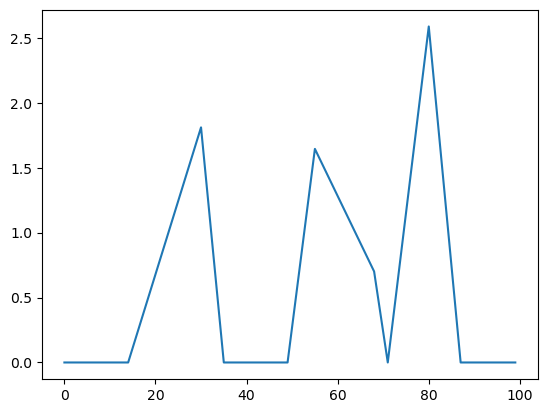

In [57]:
correct['semantic_entropy_sum-normalized'].plot.line(x='example_index', y='value')

<Axes: >

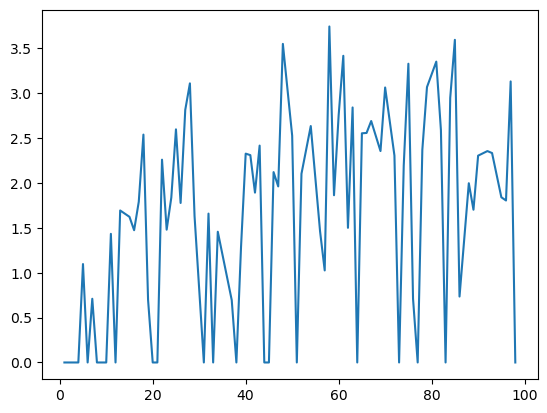

In [58]:
hall['semantic_entropy_sum-normalized'].plot.line()

In [54]:
correct['semantic_entropy']

0     5.000005
14    2.291952
30    3.421925
35    1.423664
36    1.391648
49    1.087977
55    2.673158
68    1.592832
71    0.723342
80    3.461799
87    0.522663
91    0.478211
94    0.446154
99    0.397471
Name: semantic_entropy, dtype: float64

<Axes: >

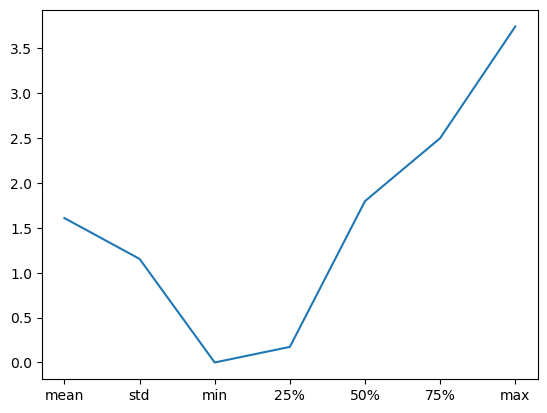

In [62]:
hall.describe()['semantic_entropy_sum-normalized'].iloc[1:].plot.line()

<Axes: >

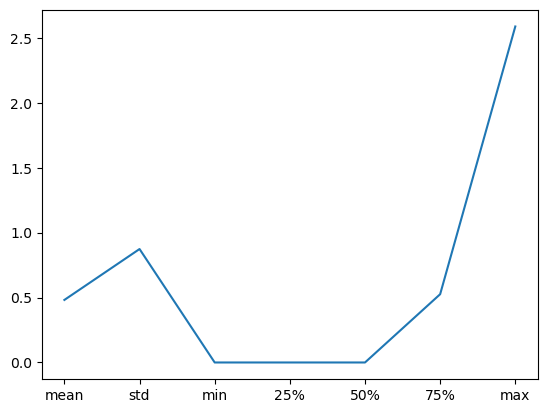

In [63]:
correct.describe()['semantic_entropy_sum-normalized'].iloc[1:].plot.line()

<Axes: >

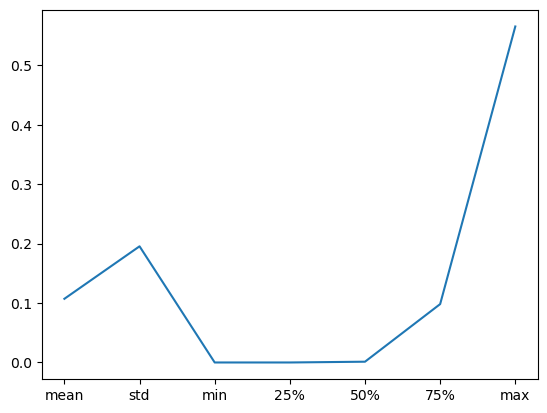

In [64]:

correct.describe()['semantic_entropy_cmean'].iloc[1:].plot.line()

<Axes: >

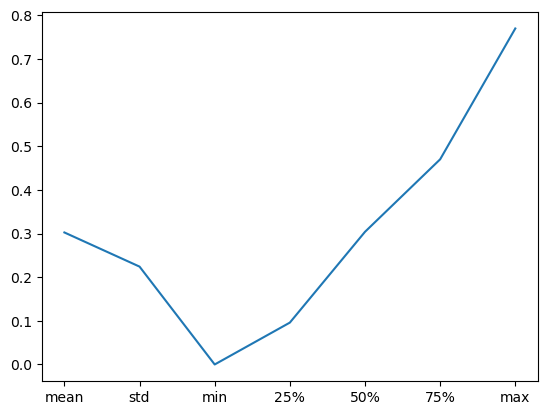

In [65]:
hall.describe()['semantic_entropy_cmean'].iloc[1:].plot.line()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([1, 2, 3, 4])
y = x*2

plt.plot(x, y)
plt.xlabel("X-axis")        # Label for the X-axis
plt.ylabel("Y-axis")        # Label for the Y-axis
plt.title("Any suitable title")  # Chart title
plt.show()

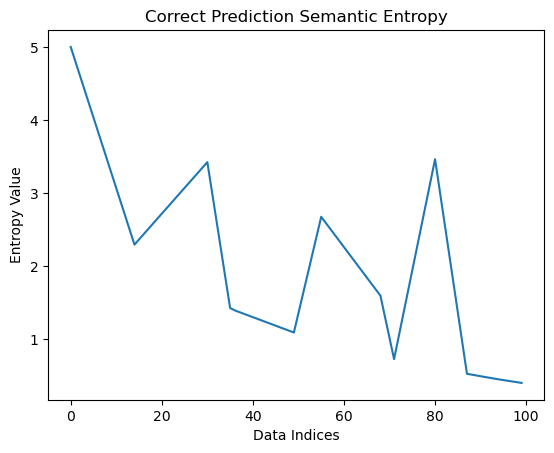

In [85]:
import matplotlib.pyplot as plt

plt.plot(correct['semantic_entropy'])

plt.ylabel("Entropy Value")
plt.xlabel("Data Indices") 
plt.title("Correct Prediction Semantic Entropy")
plt.show()
#correct['semantic_entropy'].plot(kind='line', title='Semantic Entropy')#.line(x='example_index', y='value')

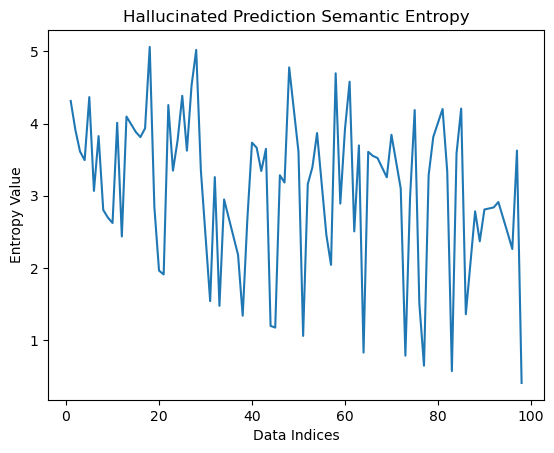

In [84]:
import matplotlib.pyplot as plt

plt.plot(hall['semantic_entropy'])

plt.ylabel("Entropy Value")
plt.xlabel("Data Indices") 
plt.title("Hallucinated Prediction Semantic Entropy")
plt.show()

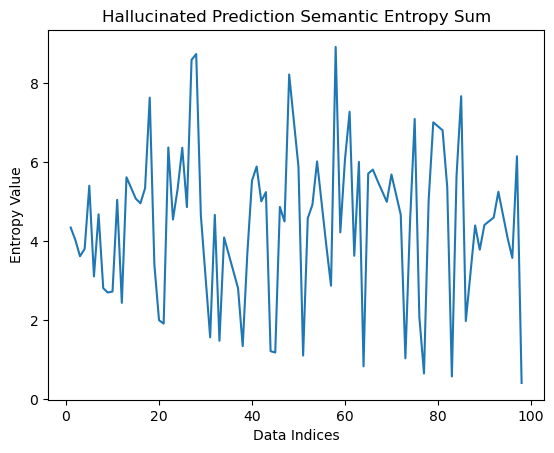

In [83]:
import matplotlib.pyplot as plt

plt.plot(hall['semantic_entropy_sum'])

plt.ylabel("Entropy Value")
plt.xlabel("Data Indices") 
plt.title("Hallucinated Prediction Semantic Entropy Sum")
plt.show()

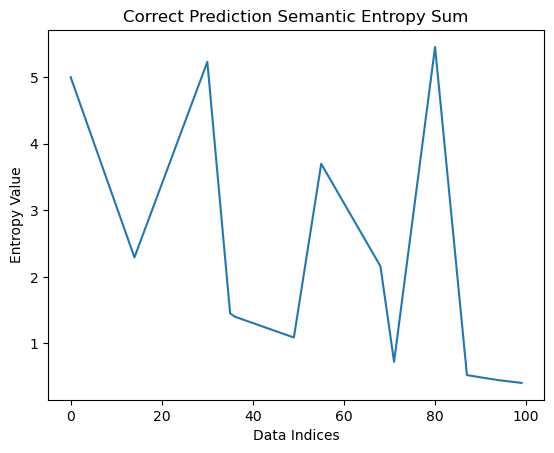

In [82]:
import matplotlib.pyplot as plt

plt.plot(correct['semantic_entropy_sum'])

plt.ylabel("Entropy Value")
plt.xlabel("Data Indices") 
plt.title("Correct Prediction Semantic Entropy Sum")
plt.show()

In [75]:
hall['semantic_entropy']

1     4.314537
2     3.915589
3     3.614393
4     3.493614
5     4.367951
        ...   
93    2.912841
95    2.482160
96    2.261825
97    3.626769
98    0.404950
Name: semantic_entropy, Length: 86, dtype: float64

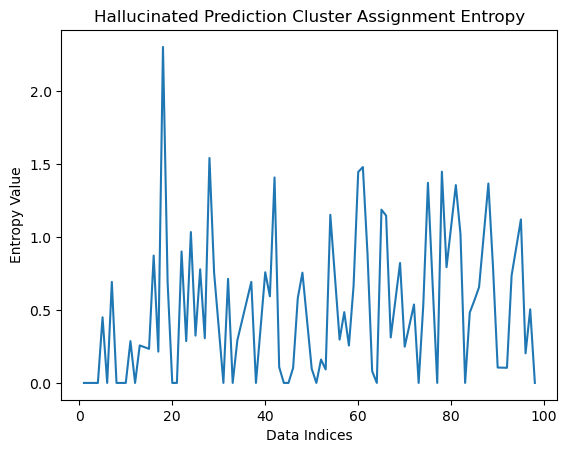

In [87]:
import matplotlib.pyplot as plt

plt.plot(hall['cluster_assignment_entropy'])

plt.ylabel("Entropy Value")
plt.xlabel("Data Indices") 
plt.title("Hallucinated Prediction Cluster Assignment Entropy")
plt.show()

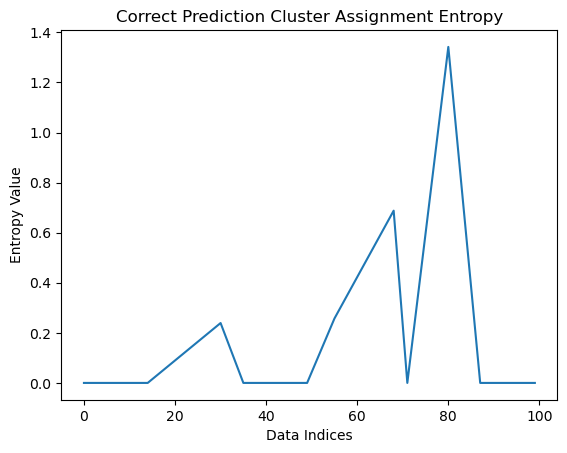

In [86]:
import matplotlib.pyplot as plt

plt.plot(correct['cluster_assignment_entropy'])

plt.ylabel("Entropy Value")
plt.xlabel("Data Indices") 
plt.title("Correct Prediction Cluster Assignment Entropy")
plt.show()